In [43]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [44]:
case_title = 'exo invalid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+1, 1.5+1+1+0.05+1]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+1, 1.5+0.033*4+1+0.05+1]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None # 0.3
    lowpass = None

    EP_lists, RT_lists = fe.pipeline_session_RT(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), move_baseline=False, detrend=1)

    if 'slow' in case:
        sessions_slow = EP_lists
        rts_slow = RT_lists
    else:
        sessions_fast = EP_lists
        rts_fast = RT_lists


In [45]:
eegs_list = [sessions_fast, sessions_slow]
rts_list = [rts_fast, rts_slow]
session_names = ["sham before", "sham after", "real before", "real after"]
freq_band_names = ["theta", "alpha", "beta", "gamma"]
region_names = ["frontal", "central", "parietal", "occipital", "temporal"] # , "all"]
stage_names_endo = ["fixation", "cue", "wait", "response", "until response"]
stage_names_exo = ["fixation", "wait", "response", "until response"]
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
endo_fast_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+0.5], [1.5+1+0.5+0.05, 1.5+1+0.5+0.05+0.3], [0, 1.5+1+0.5+0.05]]
endo_slow_stages = [[0, 1.5], [1.5, 1.5+1], [1.5+1, 1.5+1+1], [1.5+1+1+0.05, 1.5+1+1+0.05+0.3], [0, 1.5+1+1+0.05]]
exo_fast_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+0.5], [1.5+0.033*4+0.5+0.05, 1.5+0.033*4+0.5+0.05+0.3], [0, 1.5+0.033*4+0.5+0.05]]
exo_slow_stages = [[0, 1.5], [1.5+0.033*4, 1.5+0.033*4+1], [1.5+0.033*4+1+0.05, 1.5+0.033*4+1+0.05+0.3], [0, 1.5+0.033*4+1+0.05]]

if 'endo' in case_title:
    stages_list = [endo_fast_stages, endo_slow_stages]
    stage_names = stage_names_endo
else:
    stages_list = [exo_fast_stages, exo_slow_stages]
    stage_names = stage_names_exo
bp_rt = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'group_id', 'band power', 'reaction time'])

In [46]:
for i, sessions in enumerate(eegs_list):
    rts = rts_list[i]
    stage_list = stages_list[i]
    for j, session_name in enumerate(session_names):
        session_eeg = sessions[j]
        session_rt = rts[j]
        # print(session_name)
        for group_id in range(9):
            # print(group_id)
            eeg = session_eeg[group_id]
            rt = session_rt[group_id]
            for trial in range(eeg.shape[0]):
                trial_data = eeg[trial,:,:]
                for k, stage in enumerate(stage_list):
                    stage_start = int(stage[0]*fs)
                    stage_end = int(stage[1]*fs)
                    psds, freqs = mne.time_frequency.psd_array_multitaper(trial_data[:,stage_start:stage_end], fs, fmin=1, fmax=51, verbose=False)
                    for l, freq_band in enumerate(freq_bands):
                        bp = fe.band_power(psds, freqs, freq_band)
                        for region in region_names:
                            channels_dict = fe.pick_cortex(region)
                            channel_names_list = list(channels_dict.keys())
                            channels = [channels_dict[key]-1 for key in channel_names_list]
                            bp_region = np.nanmean(bp[channels])
                            new_row = pd.DataFrame({
                                'stage': [stage_names[k]],
                                'band': [freq_band_names[l]],
                                'region': [region],
                                'session': [session_name],
                                'group_id': [group_id],
                                'band power': [bp_region],
                                'reaction time': [rt[trial]]
                            })
                            bp_rt = pd.concat([bp_rt, new_row], ignore_index=True)
bp_rt
# 11 min 32 s for endo or exo
# 42 s for endo invalid
# 6 min 7.7 s for endo valid

,stage,band,region,session,group_id,band power,reaction time
0,fixation,theta,frontal,sham before,0,4.663690e-09,0.42679
1,fixation,theta,central,sham before,0,6.638111e-09,0.42679
2,fixation,theta,parietal,sham before,0,3.771457e-09,0.42679
3,fixation,theta,occipital,sham before,0,2.976085e-09,0.42679
4,fixation,theta,temporal,sham before,0,4.623374e-09,0.42679
...,...,...,...,...,...,...,...
31515,until response,gamma,frontal,real after,8,2.781480e-09,0.30282
31516,until response,gamma,central,real after,8,2.238115e-09,0.30282
31517,until response,gamma,parietal,real after,8,2.495233e-09,0.30282
31518,until response,gamma,occipital,real after,8,1.657247e-09,0.30282


In [47]:
bp_rt_session = pd.DataFrame(columns=['stage', 'band', 'region', 'session', 'band power', 'reaction time'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            for session in session_names:
                for group_id in range (9):
                    bp_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['band power'].mean()
                    rt_mean = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region) & (bp_rt['session']==session) & (bp_rt['group_id']==group_id)]['reaction time'].mean()
                    new_row = pd.DataFrame({
                        'stage': [stage],
                        'band': [band],
                        'region': [region],
                        'session': [session],
                        'band power': [bp_mean],
                        'reaction time': [rt_mean]
                    })
                    bp_rt_session = pd.concat([bp_rt_session, new_row], ignore_index=True)
bp_rt_session
# 5 m 23.3 s for endo or exo
# 1 m 2.9 s for endo invalid
# 4 m 9.4 s for endo valid

,stage,band,region,session,band power,reaction time
0,fixation,theta,frontal,sham before,6.468717e-09,0.382200
1,fixation,theta,frontal,sham before,2.332177e-09,0.273875
2,fixation,theta,frontal,sham before,4.663725e-09,0.316658
3,fixation,theta,frontal,sham before,9.129531e-09,0.292787
4,fixation,theta,frontal,sham before,5.047278e-08,0.299703
...,...,...,...,...,...,...
2875,until response,gamma,temporal,real after,4.392435e-09,0.305558
2876,until response,gamma,temporal,real after,3.613788e-09,0.286847
2877,until response,gamma,temporal,real after,2.661200e-09,0.232408
2878,until response,gamma,temporal,real after,1.418192e-09,0.352617


In [52]:
def remove_max_val(arr1, arr2):
    max_idx = np.argmax(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

def remove_min_val(arr1, arr2):
    max_idx = np.argmin(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

ccp_table = pd.DataFrame(columns=['stage', 'band', 'region', 'cc', 'p'])
for stage in stage_names:
    for band in freq_band_names:
        for region in region_names:
            bps = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]['band power'].values
            rts = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]['reaction time'].values
            bps, rts = remove_max_val(bps, rts)
            bps, rts = remove_min_val(bps, rts)
            rts, bps = remove_max_val(rts, bps)
            rts, bps = remove_min_val(rts, bps)

            bps, rts = remove_max_val(bps, rts)
            bps, rts = remove_min_val(bps, rts)
            rts, bps = remove_max_val(rts, bps)
            rts, bps = remove_min_val(rts, bps)
            cc, p = stats.pearsonr(bps, rts)
            new_row = pd.DataFrame({
                'stage': [stage],
                'band': [band],
                'region': [region],
                'cc': [cc],
                'p': [p]
            })
            ccp_table = pd.concat([ccp_table, new_row], ignore_index=True)


ccp_table.sort_values(by=['cc'], ascending=False).head(15)

,stage,band,region,cc,p
39,wait,gamma,temporal,0.363263,0.057426
59,response,gamma,temporal,0.360336,0.059616
74,until response,beta,temporal,0.341391,0.075410
14,fixation,beta,temporal,0.324709,0.091817
79,until response,gamma,temporal,0.308007,0.110811
34,wait,beta,temporal,0.288451,0.136592
19,fixation,gamma,temporal,0.274092,0.158118
54,response,beta,temporal,0.264146,0.174377
63,until response,theta,occipital,0.241770,0.215165
35,wait,gamma,frontal,0.234951,0.228784


In [49]:
# ## not by session, but by trial?
# ccp_table = pd.DataFrame(columns=['stage', 'band', 'region', 'cc', 'p'])
# for stage in stage_names:
#     for band in freq_band_names:
#         for region in region_names:
#             bps = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region)]['band power']
#             rts = bp_rt[(bp_rt['stage']==stage) & (bp_rt['band']==band) & (bp_rt['region']==region)]['reaction time']
#             cc, p = stats.pearsonr(bps, rts)
#             new_row = pd.DataFrame({
#                 'stage': [stage],
#                 'band': [band],
#                 'region': [region],
#                 'cc': [cc],
#                 'p': [p]
#             })
#             ccp_table = pd.concat([ccp_table, new_row], ignore_index=True)

# ccp_table.sort_values(by=['cc'], ascending=False).head(10)

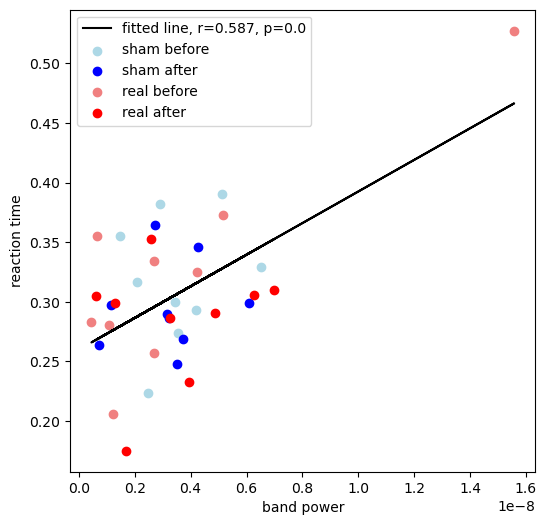

In [50]:
stage = "response"
band = "gamma"
region = "central"
bp_rt_roi = bp_rt_session[(bp_rt_session['stage']==stage) & (bp_rt_session['band']==band) & (bp_rt_session['region']==region)]
bp, rt = bp_rt_roi['band power'].values, bp_rt_roi['reaction time'].values
bp_sb, rt_sb = bp_rt_roi[bp_rt_roi['session']=='sham before']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='sham before']['reaction time'].values
bp_sa, rt_sa = bp_rt_roi[bp_rt_roi['session']=='sham after']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='sham after']['reaction time'].values
bp_rb, rt_rb = bp_rt_roi[bp_rt_roi['session']=='real before']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='real before']['reaction time'].values
bp_ra, rt_ra = bp_rt_roi[bp_rt_roi['session']=='real after']['band power'].values, bp_rt_roi[bp_rt_roi['session']=='real after']['reaction time'].values
colors = ['lightblue', 'blue', 'lightcoral', 'red']

# remove outliers
def remove_max_val(arr1, arr2):
    max_idx = np.argmax(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

def remove_min_val(arr1, arr2):
    max_idx = np.argmin(arr1)
    arr1 = np.delete(arr1, max_idx)
    arr2 = np.delete(arr2, max_idx)
    return arr1, arr2

# bp_sb, rt_sb = remove_max_val(bp_sb, rt_sb)
# bp_sa, rt_sa = remove_max_val(bp_sa, rt_sa)
# rt_ra, bp_ra = remove_min_val(rt_ra, bp_ra)
# rt_rb, bp_rb = remove_max_val(rt_rb, bp_rb)

# Concatenate all the updated band power and reaction time arrays for regression
bp = np.concatenate((bp_sb, bp_sa, bp_rb, bp_ra))
rt = np.concatenate((rt_sb, rt_sa, rt_rb, rt_ra))

# Recalculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(bp, rt)
line = slope*bp+intercept

# Update the plot
plt.figure(figsize=(6,6))
plt.plot(bp, line, 'k', label='fitted line'+', r='+str(round(r_value, 3))+', p='+str(round(p_value, 3)))

plt.scatter(bp_sb, rt_sb, label='sham before', color=colors[0])
plt.scatter(bp_sa, rt_sa, label='sham after', color=colors[1])
plt.scatter(bp_rb, rt_rb, label='real before', color=colors[2])
plt.scatter(bp_ra, rt_ra, label='real after', color=colors[3])

plt.legend()
plt.xlabel("band power")
plt.ylabel("reaction time")
plt.show()